<a href="https://colab.research.google.com/github/karanprime/DSECOP/blob/main/Gaussian_Processes_and_Schrodinger_Equation/03_GPs_for_TISE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03 Gaussian Processes and the Time-Independent Schrodinger equation
Author: Karan Shah


In [ ]:
# Get res dir and helper files
import os
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    gh_link = "Link"
    print("Colab detected. (Re)Loading helper files")
    os.system("rm -rf res")
    os.system("rm -f res.tar.gz")
    os.system(f"wget {gh_link}")
    os.system("mv res.tar.gz?raw=true res.tar.gz")
    os.system("tar -xzf res.tar.gz")

from IPython.display import display, Image, Markdown




## Introduction

Neural networks(NNs) have been shown to be good surrogate models for the Schrodinger equation for relatively simple 2D systems[1]. These models have been able to predict the ground-state energy of single electron to within chemical accuracy. An exact equicalence has been derived between infinitely wide deep neural networks and Gaussian processes(GPs)[2]. Certain kernels can be used to approximate multilayer NNs.   
In this project, we explore the use of Gaussian processes to predict the ground state energy of 2D one electron systems, given an image of electrostatic potential. We also try to reproduce the results in [1].


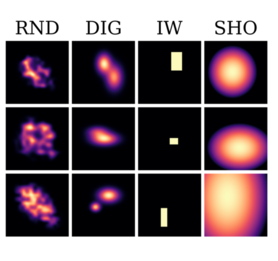

*Figure 1: Sample potentials for different systems[1]*

In [ ]:
display(Image(filename='./res/plots/four_pots.png', embed=True))
display(Markdown("*Figure 1: Sample potentials for different systems[1]*"))

#### Motivation behind GP equivalence to NN
For a single hidden layer neural network, the $i$th component of the output $z^1_i$ is given by[5,6]:
$$z_{i}^{1}(x)=b_{i}^{1}+\sum_{j=1}^{N_{1}} W_{i j}^{1} x_{j}^{1}(x), \quad x_{j}^{1}(x)=\phi\left(b_{j}^{0}+\sum_{k=1}^{d_{i n}} W_{j k}^{0} x_{k}\right)$$
where $W^0$ consists of the weights and $b$ consits of the biases of neurons.

The weights and biases are i.i.d., with distributions $w_{i,j}\sim \mathcal{N} \left(0, \sigma_w^2\right)$ and $b_i\sim \mathcal{N} \left(0, \sigma_b^2\right)$  respectively. As the number of neurons $N_1 \to \infty$, the output $z_{i}^{1} \sim \mathcal{GP} \mathcal{P}\left(0, K^{1}\right)$.
Here, the kernel function $K^{1}\left(x,x^{\prime}\right) = \sigma_{b}^{2}+\sigma_{w}^{2} C\left(x, x^{\prime}\right)$
where $C$ depends on the choice of activation function $\phi$ (defined in [5]). It is not always possible to get analytical forms for kernel function.



#### erf Kernel
An analytical form of $K^{1}$ exists for the tanh activation function. It is given by[6]:
$$
K_{\mathrm{erf}}\left(\boldsymbol{x}, \boldsymbol{x}^{\prime}\right)=\frac{2}{\pi} \sin ^{-1} \frac{2 \tilde{\boldsymbol{x}}^{T} \Sigma \tilde{\boldsymbol{x}}^{\prime}}{\sqrt{\left(1+2 \tilde{\boldsymbol{x}}^{T} \Sigma \tilde{\boldsymbol{x}}\right)\left(1+2 \tilde{\boldsymbol{x}}^{\prime T} \Sigma \tilde{\boldsymbol{x}}^{\prime}\right)}}
$$

This is our implementation:
```python
# https://papers.nips.cc/paper/1197-computing-with-infinite-networks.pdf
# sigma2 is a hyperparameter is a hyper parameter as described above

def get_kernel(self, X1, X2):
    n_train = X1.shape[0]
    n_pred = X2.shape[0]
    dim = X1.shape[1]

    X = np.concatenate((X1, X2), axis=0)
    X = np.concatenate((np.ones((n_train + n_pred, 1)), X), axis=1)

    cov_mat = self.sigma2 * np.eye(dim+1)
    K_raw = 2 * X @ (cov_mat @ X.T)
    norm = cov2varmean(1+K_raw) # returns a matrix of the geometric means of the variances in a covariance matrix

    K = np.arcsin(K_raw/norm)
    K *= 2 / np.pi

    return K
```




#### Multiple layers
Now, for multi-layer neural networks, the covariance kernel is defined recursively as[7]:
$$
K^{l}\left(x, x^{\prime}\right)=\sigma_{b}^{2}+\sigma_{w}^{2} F_{\phi}\left(K^{l-1}\left(x, x^{\prime}\right), K^{l-1}(x, x), K^{l-1}\left(x^{\prime}, x^{\prime}\right)\right)
$$
for the $l$ th layer,
with the base case:
$$
K^{0}\left(x, x^{\prime}\right)=\mathbb{E}\left[z_{j}^{0}(x) z_{j}^{0}\left(x^{\prime}\right)\right]=\sigma_{b}^{2}+\sigma_{w}^{2}\left(\frac{x \cdot x^{\prime}}{d_{\mathrm{in}}}\right)
$$
Again,the function $F_{\phi}$ depends on the activation function $\phi$ and might not have a closed form.

#### ReLU Kernel
This kernel is equivalent to an infinitely wide neural network of $l$ layers with $\phi = ReLU$ activation functions
$$
\begin{aligned} K^{l}\left(x, x^{\prime}\right) &=\sigma_{b}^{2}+\frac{\sigma_{w}^{2}}{2 \pi} \sqrt{K^{l-1}(x, x) K^{l-1}\left(x^{\prime}, x^{\prime}\right)}\left(\sin \theta_{x, x^{\prime}}^{l-1}+\left(\pi-\theta_{x, x^{\prime}}^{l-1}\right) \cos \theta_{x, x^{\prime}}^{l-1}\right) \\ \theta_{x, x^{\prime}}^{l} &=\cos ^{-1}\left(\frac{K^{l}\left(x, x^{\prime}\right)}{\sqrt{K^{l}(x, x) K^{l}\left(x^{\prime}, x^{\prime}\right)}}\right) \end{aligned}
$$
with $K_0$ defined above.
This is our implementation:
```python
# https://papers.nips.cc/paper/3628-kernel-methods-for-deep-learning.pdf
#layers, sigma_w2, sigma_b2, noise_bias are hyperparameters as described above
        
def get_K0(self, X):

    #X = normalize(X)
    d_in = X.shape[1]
    bias_kernel = np.eye(X.shape[0]) * self.noise_bias * d_in
    K0 = (np.dot(X, X.T) - bias_kernel) / d_in
    return self.sigma_b2 + self.sigma_w2 * K0

def get_kernel(self, X1, X2):
    n_train = X1.shape[0]
    n_pred = X2.shape[0]

    X = np.concatenate((X1, X2), axis=0)
    K = self.get_K0(X)


    for layer in range(self.layers):
        Kcorr = cov2cor(K) #returns correlation matrix from a covariance matrix
        theta = np.arccos(Kcorr)

        K = cov2varmean(K) * (np.sin(theta) + (np.pi - theta) * np.cos(theta))

        K *= self.sigma_w2 / (2*np.pi)
        K += self.sigma_b2

    return K
```

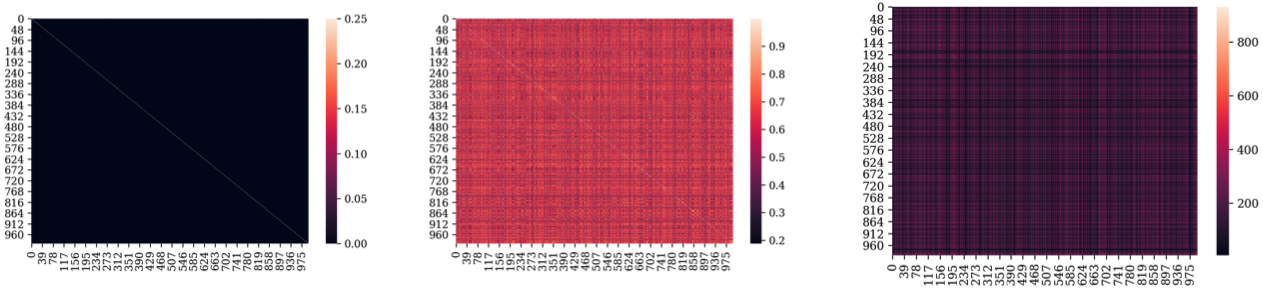

*Figure 2: Different kernels, for the potential to energy mappings. The order is [Squared exponential, erf, ReLU]*

In [ ]:
display(Image(filename='./res/plots/GP_kernels.png', embed=True))
display(Markdown("*Figure 2: Different kernels, for the potential to energy mappings. The order is [Squared exponential, erf, ReLU]*"))


A good literature review would be [2,4,5,6,7,8]. [2] also discusses numerical computation of the kernel functions.

## Results
First, each model was trained and tested on each system seperately, referred by system name. Then a generalized model trained on three systems (IW, SHO, RAND), referred to as ALL.</p>
<p>For gaussian processes, each seperate model was trained on 4000 samples and tested on 1000 samples. The generalized model was trained on IW, SHO, and RAND samples, 12000 in total, and tested on 3000 samples.</p>
<p>The CNN was trained on 16000 samples and tested on 4000 samples. The generalized model was trained on IW, SHO, and RAND samples, 48000 in total, and tested on 12000 samples.</p>


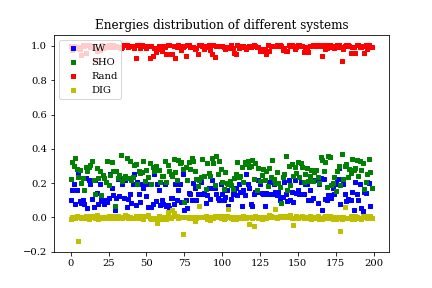

*Figure 3: True Energy distribution of different systems*

In [ ]:
display(Image(filename='./res/plots/energy_values_32.png', embed=True))
display(Markdown("*Figure 3: True Energy distribution of different systems*"))


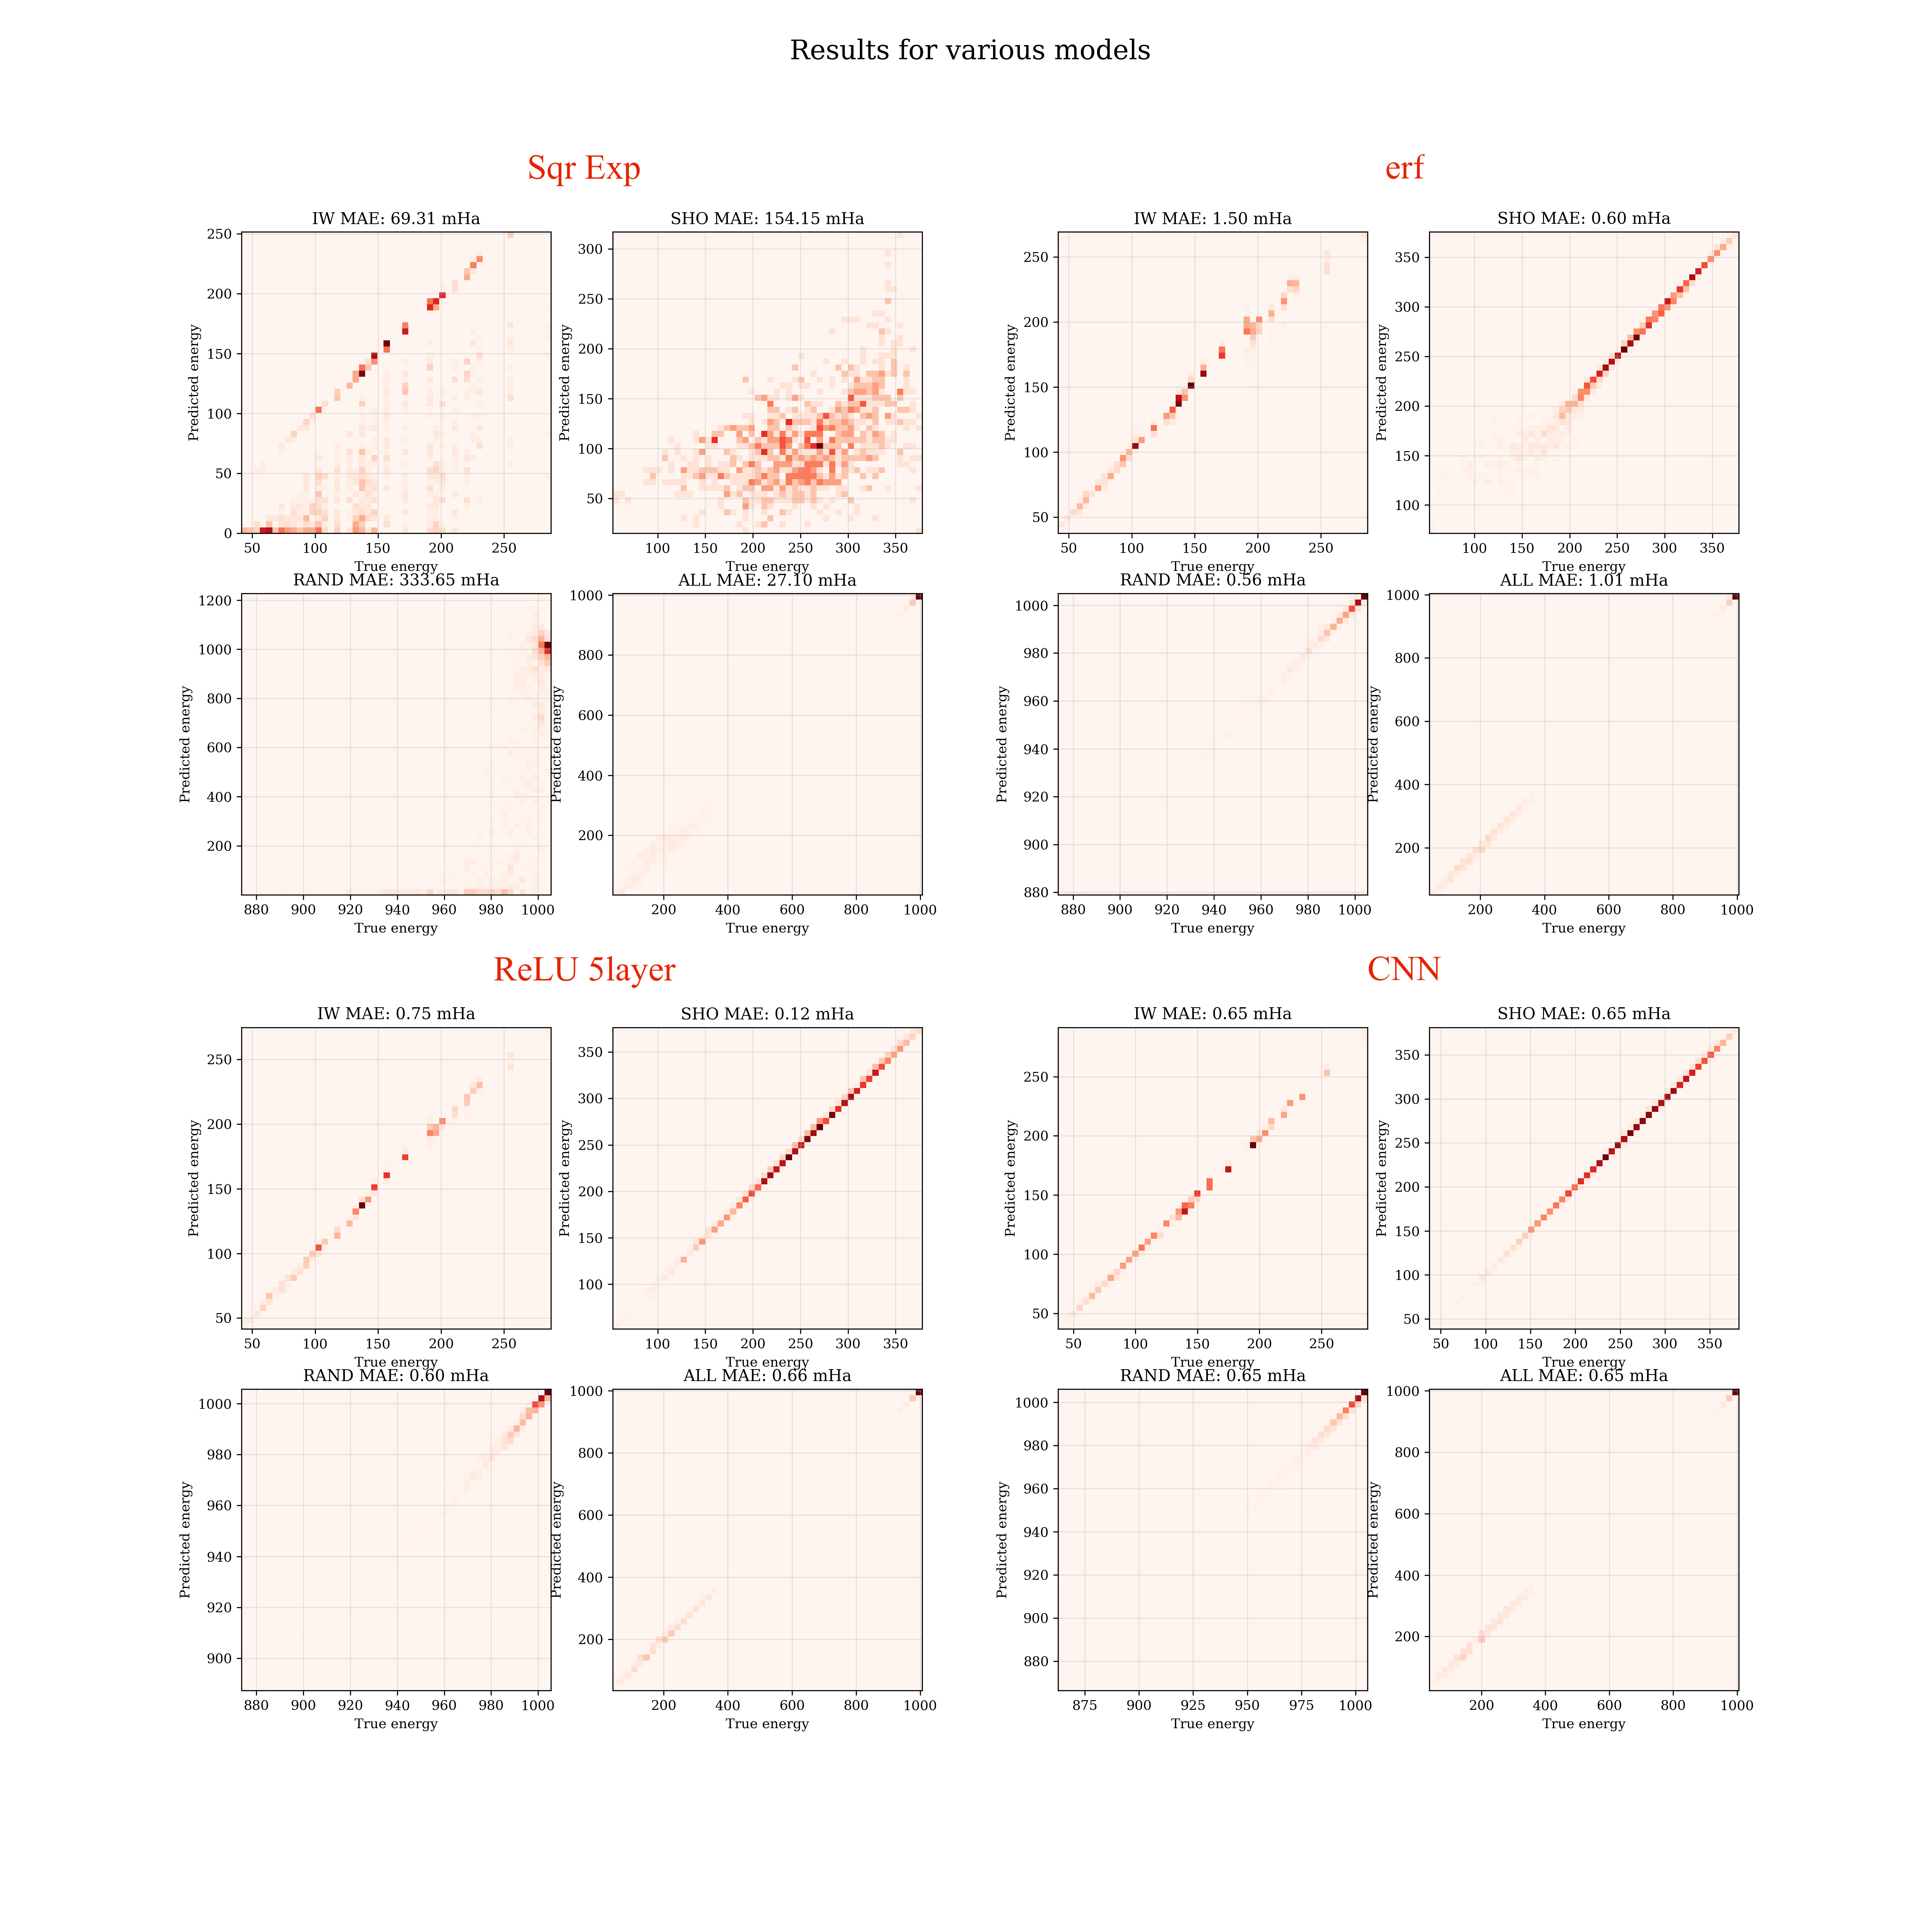

*Figure 4: Model performance different systems. All units in mHa. Each quadrant corresponds to one model, and each plot shows the predicted vs true error for that system. MAE is the median absolute error. Note the MAE for CNN are incorrect on the graph. Please refer to Table 1*

In [ ]:
display(Image(filename='./res/plots/Results.png', embed=True))
display(Markdown("*Figure 4: Model performance different systems. All units in mHa. Each quadrant corresponds to one model, and each plot shows the predicted vs true error for that system. MAE is the median absolute error. Note the MAE for CNN are incorrect on the graph. Please refer to Table 1*"))



<table>
<thead><tr>
<th></th>
<th>IW</th>
<th>SHO</th>
<th>RAND</th>
<th>ALL</th>
<th>DIG</th>
</tr>
</thead>
<tbody>
<tr>
<td>Sq Exp</td>
<td>69.3116</td>
<td>154.149</td>
<td>333.653</td>
<td>27.0994</td>
<td>7.88218</td>
</tr>
<tr>
<td>erf</td>
<td>1.49599</td>
<td>0.604144</td>
<td>0.562534</td>
<td>1.01109</td>
<td>14.4476</td>
</tr>
<tr>
<td>Relu 1l</td>
<td>0.753448</td>
<td>0.119569</td>
<td>0.597165</td>
<td>0.664624</td>
<td>205.882</td>
</tr>
<tr>
<td>Relu 5l</td>
<td>0.47914</td>
<td>0.0887508</td>
<td>0.575393</td>
<td>0.429729</td>
<td>122.52</td>
</tr>
<tr>
<td>CNN</td>
<td>0.867032</td>
<td>0.435883</td>
<td>0.537426</td>
<td>0.6508</td>
<td>54.9341</td>
</tr>
</tbody>
</table>
<center>Table 1: Median Absolute Error for each system (all units in mHa)</center>



<p>Relu 1l is a single layer relu kernel, Relu 5l is a 5 layer relu kernel.<br/>
 Relu 5l performed the best across a majority of models. Adding more layers decreased the prediction error.<br/>
 Chemical accuracy was attained on erf, both Relu layers and the CNN.</p>



<h3 id="Time">Time<a class="anchor-link" href="#Time">¶</a></h3><table>
<thead><tr>
<th></th>
<th>IW</th>
<th>SHO</th>
<th>RAND</th>
<th>ALL</th>
<th>DIG</th>
</tr>
</thead>
<tbody>
<tr>
<td>Sq Exp</td>
<td>20.231</td>
<td>21.6875</td>
<td>22.3705</td>
<td>151.493</td>
<td>106</td>
</tr>
<tr>
<td>erf</td>
<td>6.17432</td>
<td>6.54888</td>
<td>6.27394</td>
<td>21.8295</td>
<td>14.0087</td>
</tr>
<tr>
<td>Relu 1l</td>
<td>6.96452</td>
<td>7.31794</td>
<td>7.10844</td>
<td>29.1351</td>
<td>18.9333</td>
</tr>
<tr>
<td>Relu 5l</td>
<td>11.9033</td>
<td>11.9716</td>
<td>11.6958</td>
<td>69.2532</td>
<td>46.9672</td>
</tr>
<tr>
<td>CNN</td>
<td>465.491</td>
<td>468.205</td>
<td>468.594</td>
<td>2403.21</td>
<td>2403.21</td>
</tr>
</tbody>
</table>
<center> Table 2: Time taken to train model (all units in seconds) </center><p>We  experimented with the batch size and number of epochs for the CNN. On datasets of size 16000, the CNN took about 465 s and for the bigger 48000 point dataset, the CNN took 40 minutes to reach chemical accuracy.
The NNGP kernels were computed with datasets of size 5000 and 15000. It took significantly less time to reach chemical accuracy. However, the caveat here is that neural networks take much longer to train but then inference on large amounts of data is fast. Gaussian processes scale poorly when used to predict larger and larger datasets.</p>


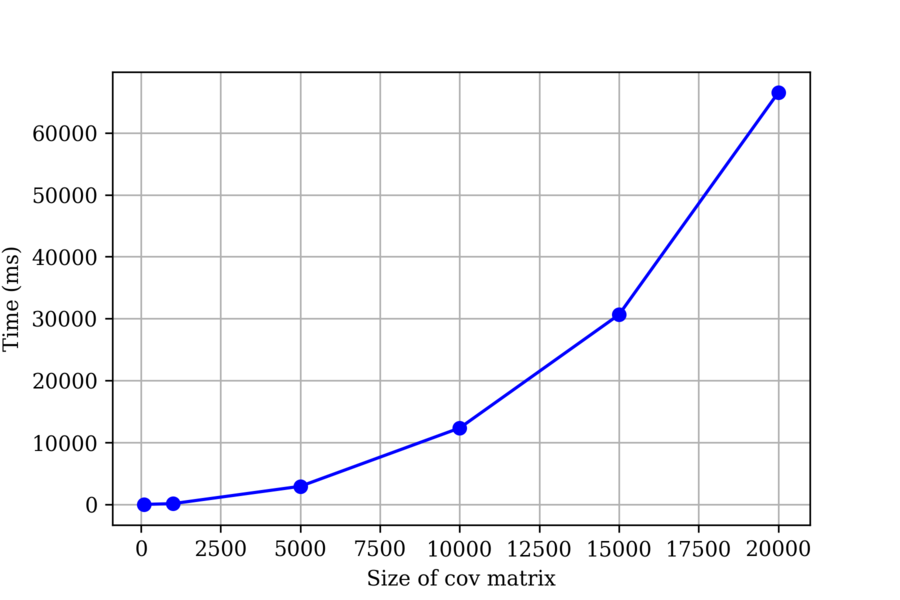

*Figure 5: Size of kernel vs time taken to invert it*

In [ ]:
display(Image(filename='./res/plots/linear_time.png', embed=True))
display(Markdown("*Figure 5: Size of kernel vs time taken to invert it*"))




### References

[1] Deep learning and the Schrodinger equation https://arxiv.org/abs/1702.01361  
[2] Deep Neural Networks as Gaussian Processes https://arxiv.org/abs/1711.00165  
[3] Uncertainty in deep learning, nice intro http://mlg.eng.cam.ac.uk/yarin/blog_2248.html  
[4] Gaussian Processes for Machine Learning http://www.gaussianprocess.org/gpml/  
[5] Priors for Infinite Networks https://www.cs.toronto.edu/~radford/pin.abstract.html, his thesis Bayesian Learning for Neural Networks is pretty cool as well https://www.cs.toronto.edu/~radford/bnn.book.html  
[7] Kernel methods for deep learning https://papers.nips.cc/paper/3628-kernel-methods-for-deep-learning.pdf  
[8] A Practical Bayesian Framework for Backpropagation Networks https://authors.library.caltech.edu/13793/1/MACnc92b.pdf
[9] Numerical Recipes, Third Ed pg 1029 http://numerical.recipes

